<a href="https://colab.research.google.com/github/narayan-bhattarai/AI-Classification/blob/main/efficient_GastroVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import time
import os

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debeshjha1/gastrovision-4")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gastrovision-4' dataset.
Path to dataset files: /kaggle/input/gastrovision-4


In [ ]:
!cp -r  path "content/dataset"

cp: cannot stat 'path': No such file or directory


In [ ]:
# device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# data augmentation

In [ ]:
import os
from PIL import Image, ImageEnhance
import random

In [ ]:
BASE_DIR = '/kaggle/input/gastrovision-4/Gastrovision 4 class'
OUTPUT_DIR = '/content/augmented_gastrovision'
CLASS = ['Colon polyps', 'Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel']

TARGET_COUNT = 820
# Define the paths for your four classes
class_dirs = {
    'Colon polyps': os.path.join(BASE_DIR, CLASS[0]),
    'Erythema': os.path.join(BASE_DIR, CLASS[1]),
    'Normal esophagus': os.path.join(BASE_DIR, CLASS[2]),
    'Normal mucosa and vascular pattern in the large bowel': os.path.join(BASE_DIR, CLASS[3]),
}

In [ ]:
# AUGMENTATION
def aggressive_augmentation(image):
    '''
    applies a random sequence of transformation to an image
    '''
    # random horizontal flip
    if random.random() < 0.5:
        image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

    # random vertical flip
    if random.random() < 0.5:
        image = image.transpose(Image.Transpose.FLIP_TOP_BOTTOM)

    # random rotation (upto 20 degrees)
    angle = random.uniform(-20, 20)
    # 2 for bilinear and 3 for bicubic
    image = image.rotate(angle, resample=Image.Resampling.BILINEAR, expand=False)

    # color jitter
    enhancer = random.choice(['Brightness', 'Contrast'])
    factor = random.uniform(0.8, 1.2)

    if enhancer == 'Brightness':
        enh = ImageEnhance.Brightness(image)
        image = enh.enhance(factor)
    elif enhancer == 'Contrast':
        enh = ImageEnhance.Contrast(image)
        image = enh.enhance(factor)

    # slight translation
    width, height = image.size

    #small shift
    if random.random() < 0.5:
        crop_area = (
            random.randint(0, width // 10),
            random.randint(0, height // 10),
            width - random.randint(0, width // 10),
            height - random.randint(0, height // 10)
        )
        image = image.crop(crop_area).resize((width, height), resample=Image.Resampling.BILINEAR)

    return image


In [ ]:
def augment_and_save(input_path, output_path, factor):

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    file_list = [f for f in os.listdir(input_path) if f.lower().endswith(('.jpg','png','jpeg'))]
    original_count = len(file_list)

    # copy original and then augment
    for i, filename in enumerate(file_list):
        image_path = os.path.join(input_path, filename)

        #1. copy the original file
        original_dest = os.path.join(output_path, f'original_{i}_{filename}')

        try:
            img = Image.open(image_path).convert('RGB')
            img.save(original_dest)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

        #2. generate augmented copies
        for j in range(factor):
            try:
                # open original image for fresh augmentation
                img = Image.open(original_dest).convert('RGB')
                augmented_image = aggressive_augmentation(img)

                # save augmented image
                aug_filename = os.path.join(output_path, f'augmented_{i}_{j}_{filename}')
                augmented_image.save(aug_filename)

            except Exception as e:
                print(f"Error processing {image_path}: {e}")
                continue
    print(f"Processed {input_path}. Original count: {original_count}. Target factor: x{factor}")
    print(f"New count in {output_path}: {len(os.listdir(output_path))}")

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print("Starting the augmentation")

for class_name, class_dir in class_dirs.items():
    output_class_dir = os.path.join(OUTPUT_DIR, class_name)

    # determine the aug factor based on class size
    original_count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('jpg','.png'))])
    if original_count < TARGET_COUNT:
        factor = int(np.ceil(TARGET_COUNT / original_count))

        #apply aug
        print(f"augmenting {class_name}")
        augment_and_save(class_dir, output_class_dir, factor)

    else:
        print(f"no augmenting just copying {class_name}")
        augment_and_save(class_dir, output_class_dir, 1)

print("finished")

Starting the augmentation
no augmenting just copying Colon polyps
Processed /kaggle/input/gastrovision-4/Gastrovision 4 class/Colon polyps. Original count: 820. Target factor: x1
New count in /content/augmented_gastrovision/Colon polyps: 1640
augmenting Erythema
Processed /kaggle/input/gastrovision-4/Gastrovision 4 class/Erythema. Original count: 15. Target factor: x55
New count in /content/augmented_gastrovision/Erythema: 840
augmenting Normal esophagus
Processed /kaggle/input/gastrovision-4/Gastrovision 4 class/Normal esophagus. Original count: 140. Target factor: x6
New count in /content/augmented_gastrovision/Normal esophagus: 980
no augmenting just copying Normal mucosa and vascular pattern in the large bowel
Processed /kaggle/input/gastrovision-4/Gastrovision 4 class/Normal mucosa and vascular pattern in the large bowel. Original count: 1467. Target factor: x1
New count in /content/augmented_gastrovision/Normal mucosa and vascular pattern in the large bowel: 2934
finished


# data loader

In [ ]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np

def create_dataloaders(
    data_dir,
    batch_size=64,
    train_split=0.7,
    val_split=0.2,
    test_split=0.1,
    random_seed=42,
):

    # Transformations
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )

    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize
    ])

    # Load dataset once
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(dataset)

    # Create shuffled indices
    np.random.seed(random_seed)
    indices = np.random.permutation(num_samples)

    # Compute split sizes
    train_end = int(train_split * num_samples)
    val_end = train_end + int(val_split * num_samples)

    train_idx = indices[:train_end]
    val_idx   = indices[train_end:val_end]
    test_idx  = indices[val_end:]

    # Create samplers
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler   = SubsetRandomSampler(val_idx)
    test_sampler  = SubsetRandomSampler(test_idx)

    # Data loaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader   = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader  = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader


In [ ]:
train_loader, valid_loader, test_loader = create_dataloaders(
    data_dir="/content/augmented_gastrovision",
    batch_size=64
)

In [ ]:
from collections import Counter

def count_classes(loader):
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.tolist())
    return dict(class_counts)


In [ ]:
dataset = train_loader.dataset

class_label = dataset.classes

print(class_label)

['Colon polyps', 'Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel']


In [ ]:
len(valid_loader)

20

In [ ]:
len(train_loader)

70

In [ ]:
print("Train:", count_classes(train_loader))
print("Val:", count_classes(valid_loader))
print("Test:", count_classes(test_loader))

Train: {3: 2057, 0: 1164, 2: 673, 1: 581}
Val: {0: 328, 2: 182, 1: 188, 3: 580}
Test: {0: 148, 1: 71, 3: 297, 2: 125}


In [ ]:
base_model = [
    # expand ratio, channel, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 2, 3],
]

phi_values = {
    # (phi_value, resolution and drop_rate)
    "b0" : (0,224,0.2),#alpha beta and gamma values for depth width and resolution
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups =1):
    super(CNNBlock, self).__init__()
    self.cnn = nn.Conv2d(
        in_channels,out_channels,kernel_size, stride, padding, groups=groups , bias = False
    )
    self.bn = nn.BatchNorm2d(out_channels)
    self.silu = nn.SiLU()


  def forward(self,x):
      return self.silu(self.bn(self.cnn(x)))


class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dims):
      super(SqueezeExcitation, self).__init__()
      self.se = nn.Sequential(
          nn.AdaptiveAvgPool2d(1), # H * W * C --> 1 * 1 * C
          nn.Conv2d(in_channels, reduced_dims, 1),
          nn.SiLU(),
          nn.Conv2d(reduced_dims, in_channels, 1),
          nn.Sigmoid(),
      )

    def forward(self,x):
        return x*self.se(x)


class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, expand_ratio, reduction =4, survival_prob = 0.8):
      # reduction is for the squueze excitation and survival prob is for the stochastic depth
      super(InvertedResidualBlock, self).__init__()
      self.survival_prob = 0.8
      self.use_residual = in_channels==out_channels and stride == 1
      hidden_dims = in_channels * expand_ratio
      self.expand = in_channels != hidden_dims

      reduced_dims = int(in_channels / reduction)

      if self.expand:
        self.expand_conv = CNNBlock(
            in_channels, hidden_dims, kernel_size = 3 , stride = 1, padding = 1,
        )

      self.conv = nn.Sequential(CNNBlock(
              hidden_dims, hidden_dims, kernel_size, stride, padding, groups = hidden_dims,
          ),
          SqueezeExcitation(hidden_dims, reduced_dims),
          nn.Conv2d(hidden_dims, out_channels, 1, bias = False),
          nn.BatchNorm2d(out_channels),
      )

    def stochastic_depth(self,x):
      if not self.training:
        return x

      binary_tensor = torch.rand(x.shape[0],1,1,1,device=x.device) < self.survival_prob

      return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
      x = self.expand_conv(inputs) if self.expand else inputs

      if self.use_residual:
        return self.stochastic_depth(self.conv(x)) +inputs
      else:
        return self.conv(x)


class EfficientNet(nn.Module):
  def __init__(self, version, num_classes):
    super(EfficientNet, self).__init__()

    width_factor, depth_factor , dropout_rate = self.calculate_factors(version)
    last_channels = ceil(1280 * width_factor)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.features = self.create_features(width_factor, depth_factor, last_channels)
    self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
    )

  def calculate_factors(self, version, alpha=1.2, beta=1.1):
      phi, res, drop_rate = phi_values[version]
      depth_factor = alpha**phi
      width_factor = beta**phi
      return width_factor, depth_factor, drop_rate

  def create_features(self, width_factor, depth_factor, last_channels):
      channels = int(32 * width_factor)
      features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
      in_channels = channels

      for expand_ratio, channels, repeats, stride, kernel_size in base_model:
          out_channels = 4 * ceil(int(channels * width_factor) / 4)
          layers_repeats = ceil(repeats * depth_factor)

          for layer in range(layers_repeats):
              features.append(
                  InvertedResidualBlock(
                      in_channels,
                      out_channels,
                      expand_ratio=expand_ratio,
                      stride=stride if layer == 0 else 1,
                      kernel_size=kernel_size,
                      padding=kernel_size // 2,  # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                  )
              )
              in_channels = out_channels

      features.append(
          CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
      )

      return nn.Sequential(*features)


  def forward(self, x):
      x = self.pool(self.features(x))
      return self.classifier(x.view(x.shape[0], -1))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()

        # Convert alpha to a tensor if it's a float or list, otherwise keep it as None
        if isinstance(alpha, (float, list)):
            # Registering as a buffer handles moving the weights to GPU (cuda) automatically
            self.register_buffer('alpha_tensor', torch.tensor(alpha))
            alpha_param = self.alpha_tensor
        else:
            alpha_param =alpha
        self.CE_loss = nn.CrossEntropyLoss(reduction='none', weight=alpha_param)
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Ensure inputs are probabilities (e.g., after sigmoid)
        # If inputs are logits, apply sigmoid first:
        ce_loss = self.CE_loss(inputs, targets)
        pt = torch.exp(-ce_loss)

        # we donot apply alpha here if we don't use the weight argument
        # or we use F.binary_cross_entropy_with_logits
        focal_loss = (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [ ]:
num_classes = 4
num_epochs = 20
eval_interval = 5 #validation interval

batch_size = 32
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = EfficientNet("b0", 10)
# print(model)

# Load pre-trained EfficientNet-B0 weights
weights = EfficientNet_B5_Weights.IMAGENET1K_V1

# Initialize the model with pre-trained weights
model = efficientnet_b5(weights=weights)

# Set the model to evaluation mode
model.eval()

# If you want to use the model for a different number of classes,
# you need to modify the final classifier layer.
# For example, to change the output to 10 classes:
num_classes = 4
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)
model = model.to(device)
print('Device: ',device)

# You must define weights for ALL 4 classes.
# class_weights = [0.9, 0.20, 0.4, 1.0]
class_weights = [0.77, 1.51, 1.29, 0.43]

# Convert the list to a PyTorch tensor (optional, the FocalLoss class handles this, but good practice)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=weights_tensor, gamma=2)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# train the model
total_step = len(train_loader)
print("total steps", total_step)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth


100%|██████████| 117M/117M [00:00<00:00, 123MB/s]


Device:  cuda
total steps 70


In [ ]:
trainingEpoch_loss = []

# defining a directory to save weights
save_dir = "/content/weights/EfficientNet/"
os.makedirs(save_dir, exist_ok = True)

for epoch in range(num_epochs):
    # running_loss = 0.0
    step_loss = []
    # Training
    model.train()
    t0 = time.time()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() #clearing gradients
        outputs = model(inputs) #forward pass
        loss = criterion(outputs, labels) #find loss
        loss.backward() #calculate gradients
        optimizer.step() #update weights
        # running_loss += loss.item()
        step_loss.append(loss.item())

    trainingEpoch_loss.append(np.array(step_loss).mean())

    t1 = time.time()

    # Create a file name for the saved weights based on the epoch
    file_name = f"model_weightseff_epoch{epoch}.pth"
    # Save the model weights
    torch.save(model.state_dict(), os.path.join(save_dir, file_name))

    # Print average training loss for each epoch
    # train_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}, Time: {t1-t0}")

    # testing
    with torch.no_grad():
        correct = 0
        total = 0

        all_preds = []
        all_labels = []

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            del images, labels, outputs

        print('Accuracy of the network on the validation images: {} %'.format(100 * correct / total))
         # Added metrics
        print("Test Classification Report:")
        print(classification_report(all_labels, all_preds, digits=4))
        print("Macro F1 Score:", f1_score(all_labels, all_preds, average='macro'))
        print("Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
        print("Macro Recall:", recall_score(all_labels, all_preds, average='macro'))


    # validation
    if (epoch + 1) % eval_interval == 0:
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0

            all_preds = []
            all_labels = []

            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            accuracy = 100 * correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy}%")
            # Added metrics
            print("Validation Classification Report:")
            print(classification_report(all_labels, all_preds, digits=4))
            print("Macro F1 Score:", f1_score(all_labels, all_preds, average='macro'))
            print("Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
            print("Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

Epoch [1/20], Training Loss: 0.04136475548148155, Time: 53.55073881149292
Accuracy of the network on the validation images: 85.02340093603745 %
Test Classification Report:
              precision    recall  f1-score   support

           0     0.6462    0.9257    0.7611       148
           1     0.8537    0.9859    0.9150        71
           2     0.9919    0.9760    0.9839       125
           3     0.9643    0.7273    0.8292       297

    accuracy                         0.8502       641
   macro avg     0.8640    0.9037    0.8723       641
weighted avg     0.8840    0.8502    0.8531       641

Macro F1 Score: 0.8722973556747735
Macro Precision: 0.8640101461661517
Macro Recall: 0.9037159739765375
Epoch [2/20], Training Loss: 0.008982419967651367, Time: 51.492634296417236
Accuracy of the network on the validation images: 90.01560062402496 %
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7263    0.9324    0.8166       148
      

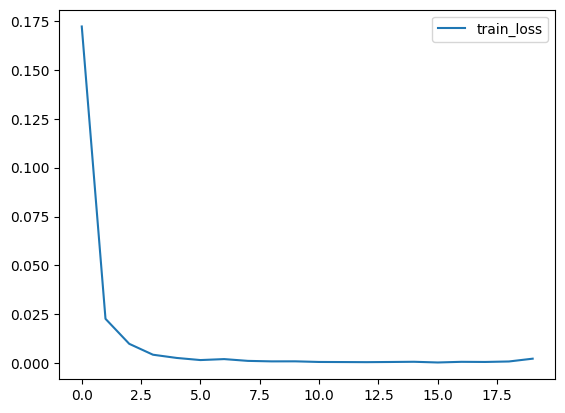

In [ ]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.legend()
plt.show()

# grad cam

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=4d86dde17e478c1e32bf1d68d9f67f605967fde337e97556a2d411b5e8fd2600
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from google.colab.patches import cv2_imshow
def grad_cam(model, pred, image):
    target_layer = model.features[-1]

    #preprocess image
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                            std=[0.2023, 0.1994, 0.2010])
    ])

    image = Image.open(image)
    input_tensor = transform(image).unsqueeze(0)

    # creting a grad cam object
    cam = GradCAM(model=model, target_layers=[target_layer])
    input_tensor = input_tensor.to(device)
    #target category
    targets = [ClassifierOutputTarget(pred)]
    # generating heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    #convert image for overlay
    rgb_img = np.float32(image.resize((227,227))) / 255
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(image)
    plt.axis('off')  # hide axes
    plt.show()
    cv2_imshow(visualization)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

torch.save(model.state_dict(), "/content/final_epoch_model.pt")

In [ ]:
from PIL import Image

In [ ]:
# #model load
# checkpoint = torch.load("/content/weights/EfficientNet/model_weightseff_epoch7.pth")
# model.load_state_dict(checkpoint)
# model.eval()

Normal esophagus test

In [ ]:
# Preprocess the image
image_path = "/kaggle/input/gastrovision-4/Gastrovision 4 class/Normal esophagus/0002fe04-7ee9-42aa-b951-bcaedb70d8b1.jpg"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])
input_image = transform(image).unsqueeze(0)

tensor([2], device='cuda:0')


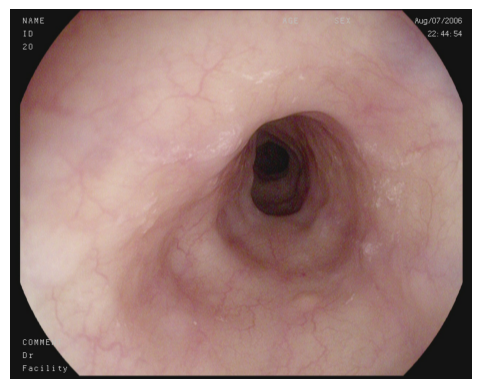

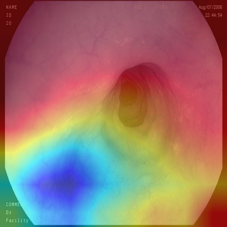

Predicted class: Normal esophagus
Probability: 0.9999642372131348


In [ ]:
# Forward pass
with torch.no_grad():
  input_image = input_image.to(device)
  output = model(input_image)


_, predicted = torch.max(output.data, 1)

print(predicted)

# Get the predicted class probabilities
probabilities = torch.nn.functional.softmax(output, dim=1)[0]

# Get the predicted class label
predicted_class = torch.argmax(probabilities).item()

class_labels = ['Colon polyps', 'Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel']

grad_cam(model, predicted_class, image_path)

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

Erythema test

In [ ]:
# Preprocess the image
image_path = "/kaggle/input/gastrovision-4/Gastrovision 4 class/Erythema/03bf7e9a-fb31-4f03-a827-fd0b634c4af2.jpg"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])
input_image = transform(image).unsqueeze(0)

tensor([1], device='cuda:0')


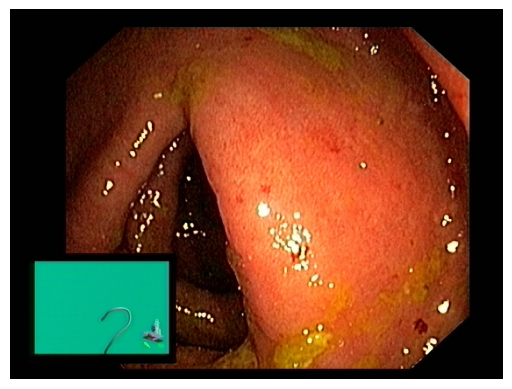

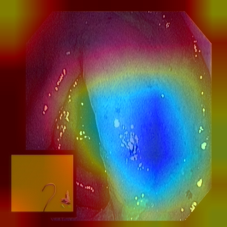

Predicted class: Erythema
Probability: 0.9998779296875


In [ ]:
# Forward pass
with torch.no_grad():
  input_image = input_image.to(device)
  output = model(input_image)


_, predicted = torch.max(output.data, 1)

print(predicted)

# Get the predicted class probabilities
probabilities = torch.nn.functional.softmax(output, dim=1)[0]

# Get the predicted class label
predicted_class = torch.argmax(probabilities).item()

class_labels = ['Colon polyps', 'Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel']

grad_cam(model, predicted_class, image_path)

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

Normal mucosa and vascular pattern test

In [ ]:
# Preprocess the image
image_path = "/kaggle/input/gastrovision-4/Gastrovision 4 class/Normal mucosa and vascular pattern in the large bowel/00c1197e-a3b3-4a83-a29f-ebf2013babc7.jpg"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])
input_image = transform(image).unsqueeze(0)

tensor([3], device='cuda:0')


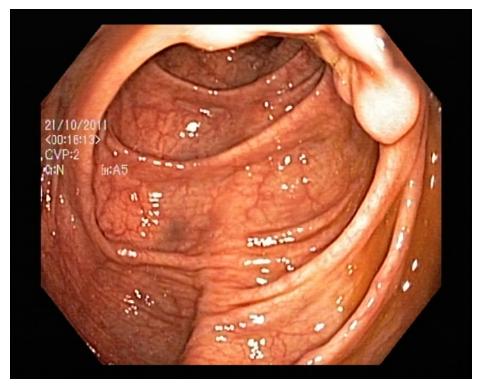

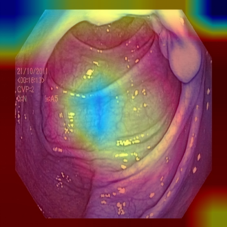

Predicted class: Normal mucosa and vascular pattern in the large bowel
Probability: 0.8736251592636108


In [ ]:
# Forward pass
with torch.no_grad():
  input_image = input_image.to(device)
  output = model(input_image)


_, predicted = torch.max(output.data, 1)

print(predicted)

# Get the predicted class probabilities
probabilities = torch.nn.functional.softmax(output, dim=1)[0]

# Get the predicted class label
predicted_class = torch.argmax(probabilities).item()

class_labels = ['Colon polyps', 'Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel']

grad_cam(model, predicted_class, image_path)

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

Colon Polyp test

In [ ]:
# Preprocess the image
image_path = "/kaggle/input/gastrovision-4/Gastrovision 4 class/Colon polyps/00a5d194-4aa1-495a-afff-5ef6ad6ad3a0.jpg"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])
input_image = transform(image).unsqueeze(0)

tensor([0], device='cuda:0')


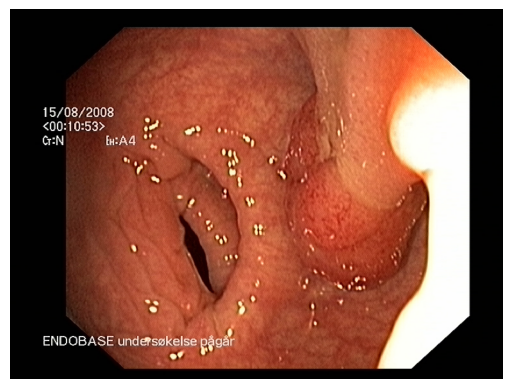

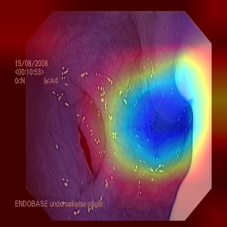

Predicted class: Colon polyps
Probability: 0.9950323104858398


In [ ]:
# Forward pass
with torch.no_grad():
  input_image = input_image.to(device)
  output = model(input_image)


_, predicted = torch.max(output.data, 1)

print(predicted)

# Get the predicted class probabilities
probabilities = torch.nn.functional.softmax(output, dim=1)[0]

# Get the predicted class label
predicted_class = torch.argmax(probabilities).item()

class_labels = ['Colon polyps', 'Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel']

grad_cam(model, predicted_class, image_path)

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


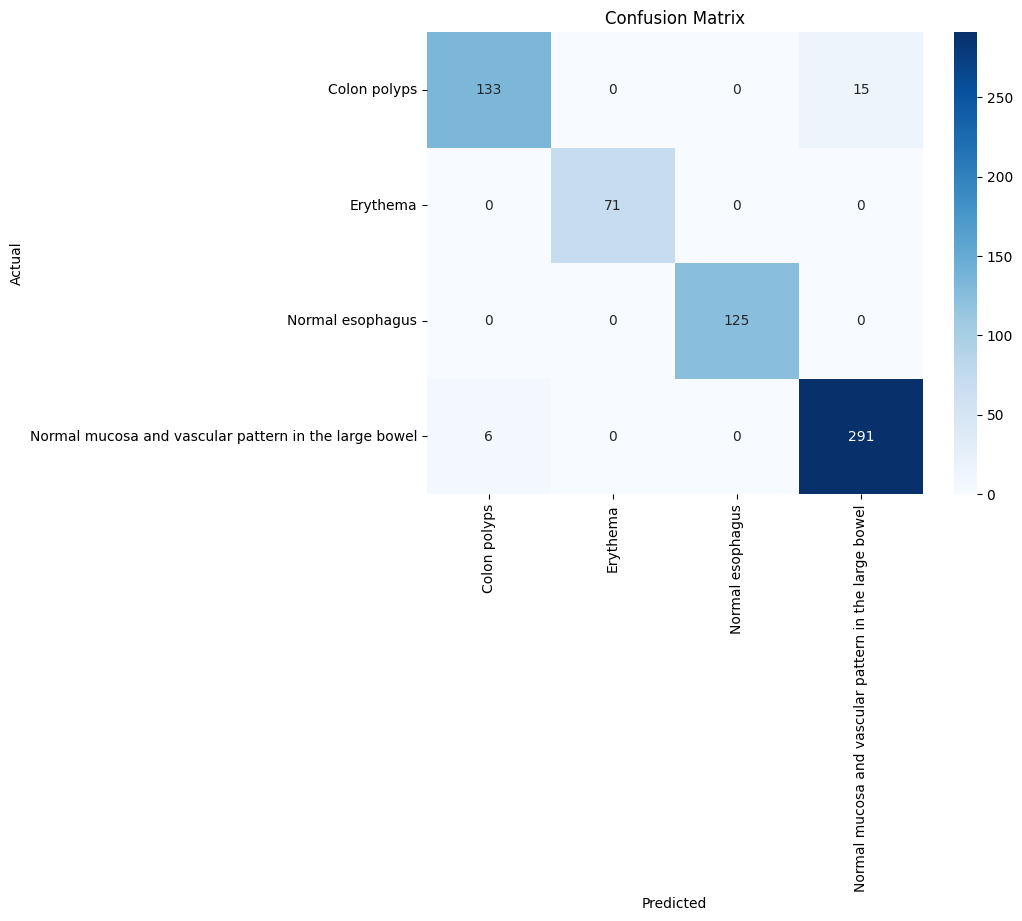

In [ ]:
plot_confusion_matrix(model, test_loader, CLASS)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model, loader, num_classes):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)

            y_true.extend(labels.cpu().numpy())
            y_score.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # One-vs-rest binarization
    y_bin = label_binarize(y_true, classes=list(range(num_classes)))

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.3f})")

    # Plot macro-average AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle='--',
             label=f"Macro AUC = {roc_auc_micro:.3f}")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend()
    plt.show()


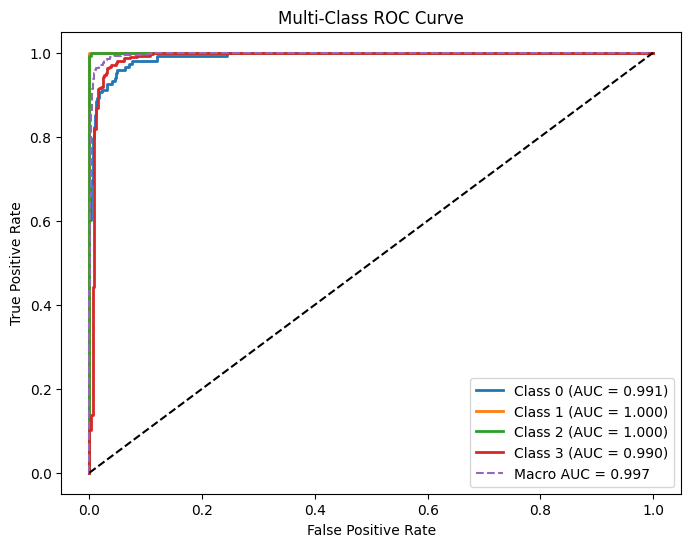

In [ ]:
plot_multiclass_roc(model, test_loader, num_classes=4)